# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (50, 400), instead if (10, 2.27). The simulation exercises are always with 200 buses over 70000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 78.

In [1]:
extract_zips()

# Transition probabilities

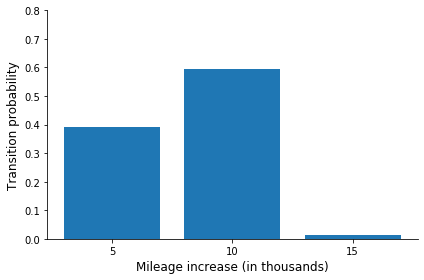

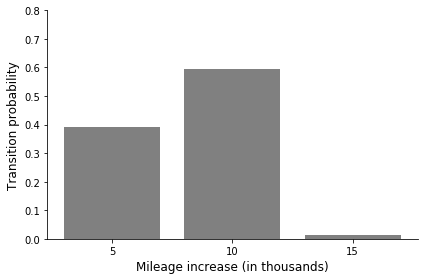

In [4]:
state = 30
get_probabilities(state)

[ 1.21788598  1.6035251  -2.22194964]
[[0.51506653 0.47268376 0.01200837]
 [0.47268376 0.51002241 0.01705365]
 [0.01200837 0.01705365 0.97141948]]
[[0.11752727 0.15322771 0.01160969]
 [0.13850167 0.1098567  0.10204319]]


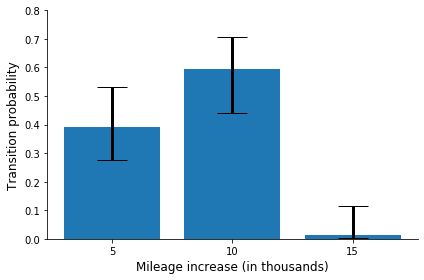

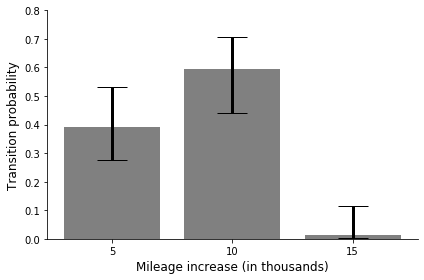

In [9]:
get_probabilities_bar(state)

In [47]:
df_probability_shift(state)

,0,4292_0.50,4292_0.95,2223_0.95
0,0.391892,0.316675,0.240324,0.188232
1,0.595294,0.665463,0.733249,0.775076
2,0.012815,0.017863,0.026428,0.036691


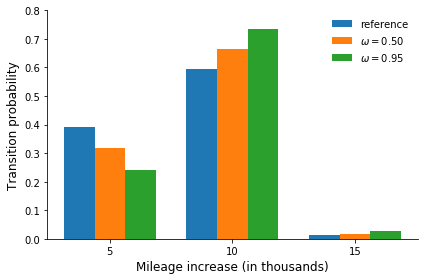

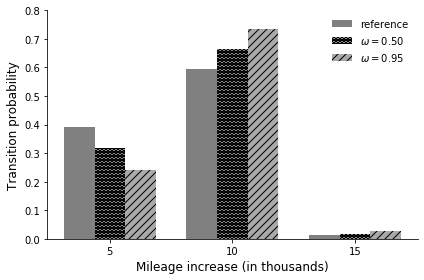

In [48]:
get_probability_shift(state)

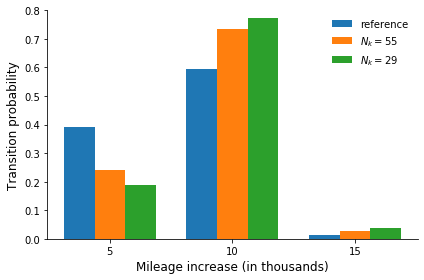

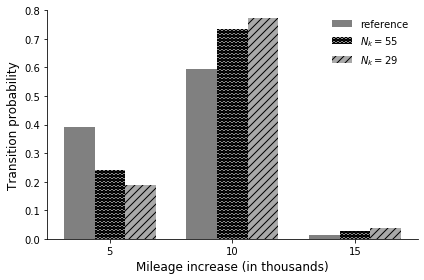

In [49]:
get_probability_shift_data(state)

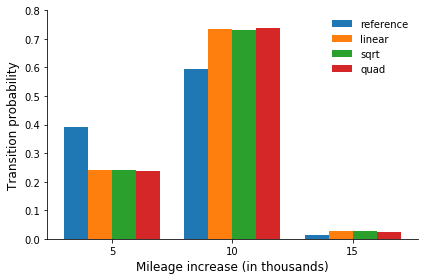

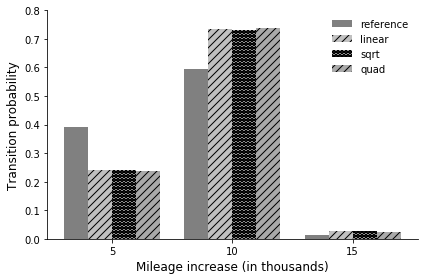

In [56]:
get_probability_shift_models(state, 0.95)

# Policy Features
 

In [12]:
min_states = {
    "linear": 0,
    "sqrt": 0,
    "quad": 0,
}
max_states = {
    "linear": 80,
    "sqrt": 80,
    "quad": 80,
}
state_steps = {
    "linear": 5,
    "sqrt": 5,
    "quad": 5,
}
# df_maintenance_probabilties_lin(min_states["linear"], max_states["linear"])

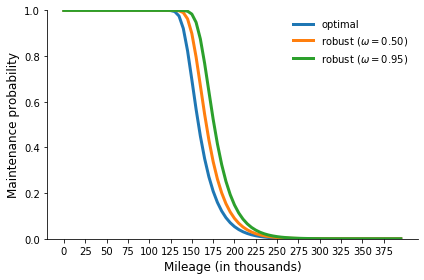

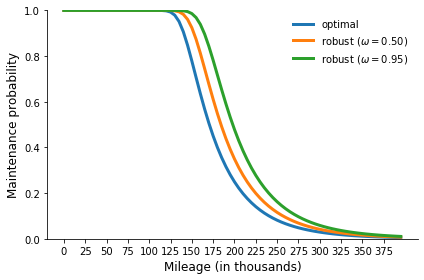

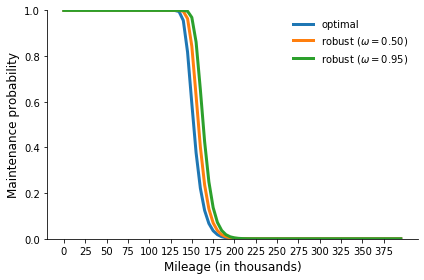

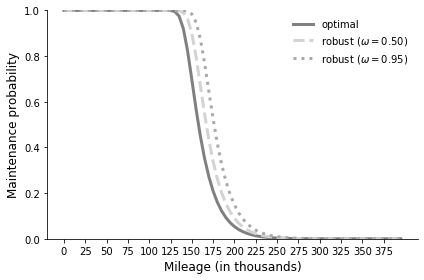

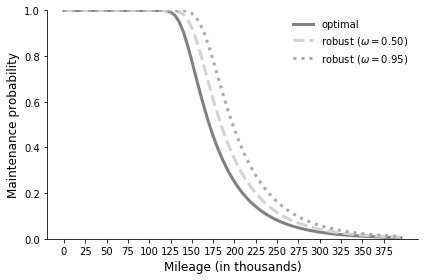

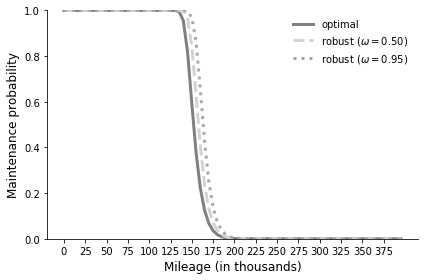

In [13]:
get_maintenance_probabilities(min_states, max_states, state_steps)

# Policy performance

In [72]:
max_period = 120

init_dict = {
    "beta": 0.9999,
    "buses": 1,
    "periods": 200,
    "seed": 15,
}
df = get_demonstration_df(init_dict, max_period)

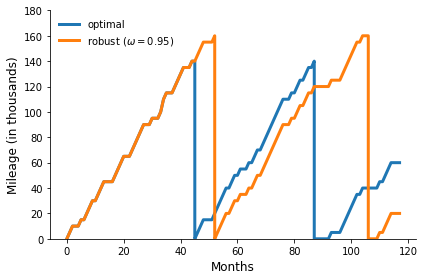

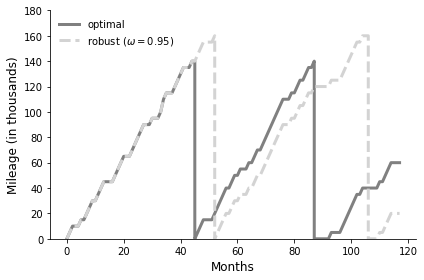

In [73]:
max_mileage = 180
get_demonstration(df, max_period, max_mileage)

In [23]:
df_thresholds("linear")

,omega,threshold
0,0.00000,30
1,0.04125,30
2,0.08250,31
3,0.12375,31
4,0.16500,31
5,0.20625,31
6,0.24750,31
7,0.28875,31
8,0.33000,31
9,0.37125,31


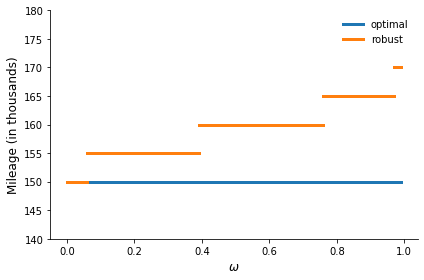

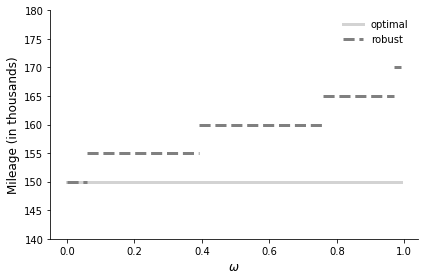

In [24]:
get_replacement_thresholds("linear")

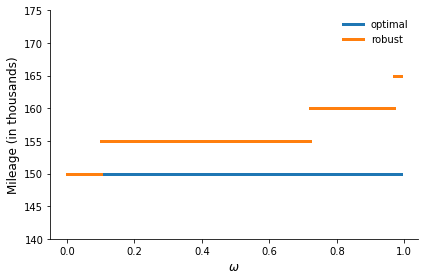

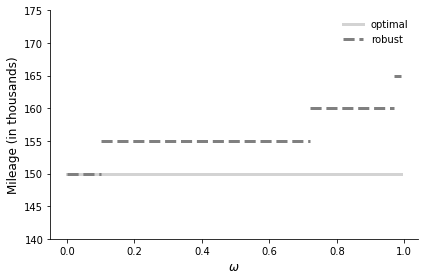

In [25]:
get_replacement_thresholds("quad")

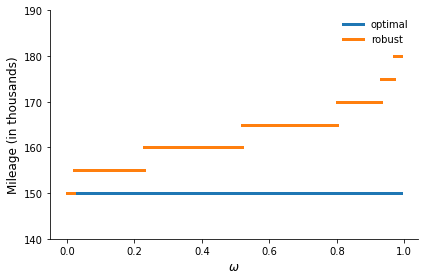

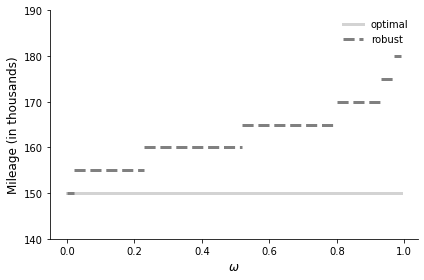

In [26]:
get_replacement_thresholds("sqrt")

In [28]:
get_decision_rule_df("linear")

,months,disc_strategy,exp_value
0,0,0.000000,-81794.349388
1,1000,-8713.741110,-81794.349388
2,2000,-16711.157211,-81794.349388
3,3000,-23949.873659,-81794.349388
4,4000,-30500.465464,-81794.349388
...,...,...,...
71,71000,-92702.790176,-81794.349388
72,72000,-92710.085333,-81794.349388
73,73000,-92716.682869,-81794.349388
74,74000,-92722.661289,-81794.349388


The underlying transition matrix is the worst case given omega=0.95
1.133673133217868 1.0053853161029507


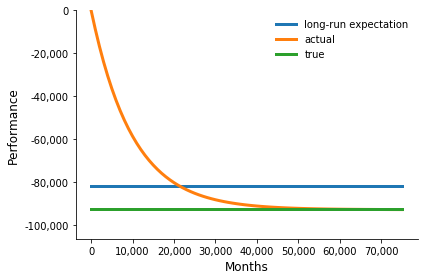

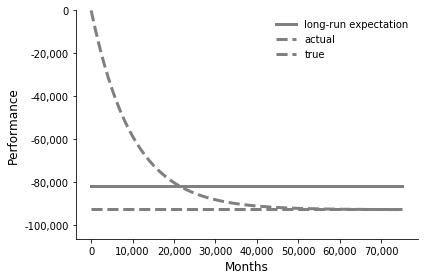

In [29]:
get_performance_decision_rules("linear")

The underlying transition matrix is the worst case given omega=0.95
1.090102769494124 1.0049220495324989


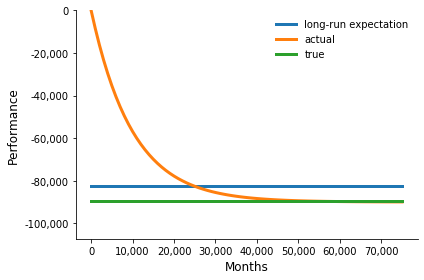

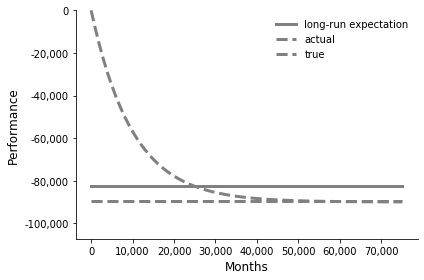

In [30]:
get_performance_decision_rules("sqrt")

The underlying transition matrix is the worst case given omega=0.95
1.1792734999686731 1.0044942869310083


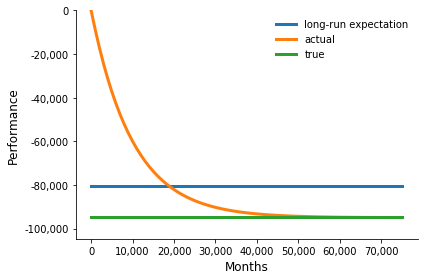

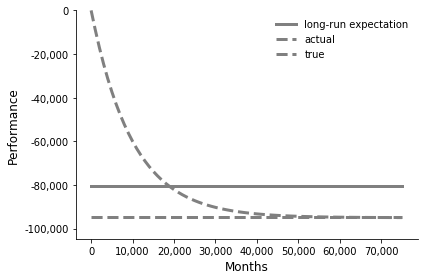

In [31]:
get_performance_decision_rules("quad")

In [ ]:
df[df["omega"] == 0.04]

[-474.97453234 -375.54175247 -317.61415584 -282.15336272 -254.05712199
 -206.31074177 -183.1747928  -156.7443714  -116.8187067   -79.36086387
  -41.80899333  -32.64994905   14.60235016   50.28882902   69.003127
  112.31513063  144.58389323  173.12484361  198.59615972  260.35747373
  291.68374566  361.7067838   460.47891417  567.20967987  783.71535926]
[-121.48003306  -76.13356494  -27.34723298  -27.02886053   14.06846965
   20.74603987   44.25330885   58.04950364   60.63420668   98.44070588
  113.4409456   114.84990319  145.09795888  167.30478114  171.45258868
  195.70348707  201.7198514   207.08385315  233.53198191  270.0742406
  284.81531838  326.87356462  377.592329    427.18873717  559.23757061]


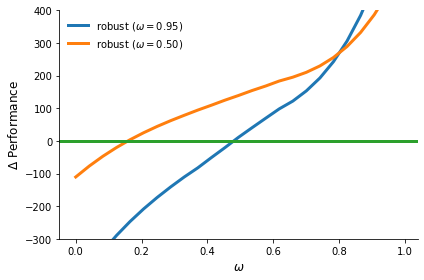

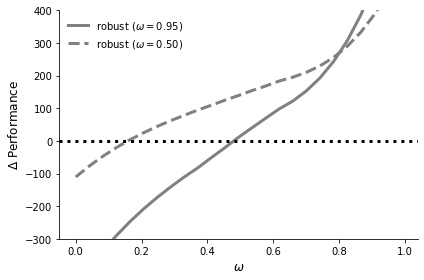

In [37]:
window_length = 17
get_difference_plot("linear", window_length)

[-4.29463098e+02 -3.35347656e+02 -3.02524402e+02 -2.40588262e+02
 -2.15267213e+02 -1.84935736e+02 -1.57180100e+02 -1.15662197e+02
 -1.03958426e+02 -9.73322171e+01 -3.21275772e+01 -6.34369749e-01
 -8.06935071e+00  3.68437585e+01  7.10603918e+01  9.59295078e+01
  1.43494782e+02  1.28012463e+02  1.85810236e+02  2.43037354e+02
  2.60000688e+02  3.02110969e+02  3.89989157e+02  4.87650143e+02
  7.00062696e+02]
[-111.03149058  -61.42690903  -45.55359359  -20.18262795    9.08165145
   34.6507193    55.87938475   44.23557086   65.92530838   75.31783229
   82.90905794  103.84326531  116.99874465  110.29855688  161.01360997
  162.15381439  174.90756557  179.74034697  219.06460372  228.22956627
  265.22347005  272.99471634  308.84969101  360.98323963  467.29048847]


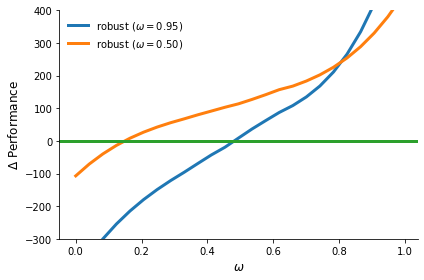

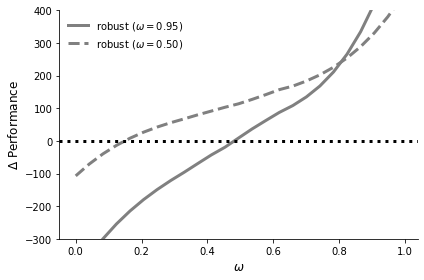

In [38]:
get_difference_plot("quad", window_length)

[-443.63382103 -335.94714563 -280.07436463 -245.01789564 -222.01903769
 -178.63037346 -154.75883692 -113.35884866  -88.2675901   -70.51303928
  -38.73664021  -15.226151      9.77291435   40.41011576   70.97944519
   87.96016047  130.35608966  164.06375676  193.25293245  246.57406664
  290.89708154  354.78188356  413.49534149  506.29586444  711.40409039]
[-127.04512975  -67.91019447  -36.74830595  -15.83607959   -9.34695347
   21.285035     18.00823433   56.45542523   77.04511355   78.3236007
   98.67730155  115.75130861  125.30855806  145.68885589  155.1931468
  178.52396868  188.86275577  197.21051393  225.03247299  241.29802684
  263.81182574  302.46443337  343.55462551  388.91369917  488.86797029]


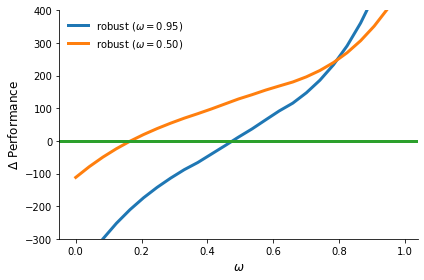

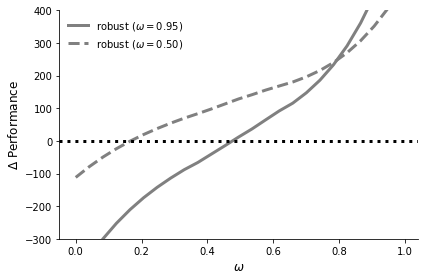

In [39]:
get_difference_plot("sqrt", window_length)

# Out of sample performance

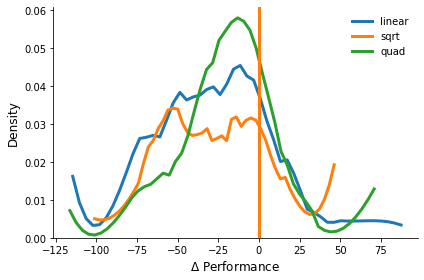

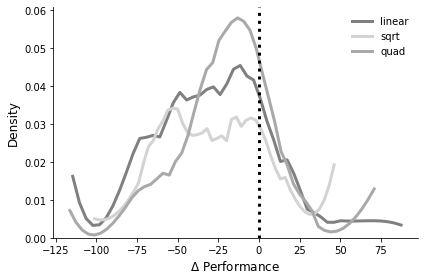

In [35]:
get_out_of_sample_diff(0.12, 50, 19)

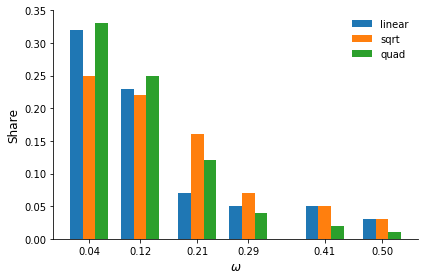

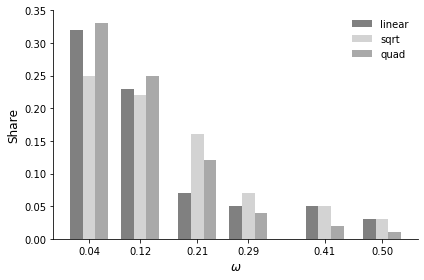

In [36]:
keys = [0.04, 0.12, 0.21, 0.29, 0.41, 0.5]
width = 0.02
get_robust_performance(keys, width)